In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import welch

from kalman_experiments import SSPE
from kalman_experiments.model_selection import (
    estimate_sigmas,
    get_psd_val_from_est,
    theor_psd_ar,
    theor_psd_mk_mar,
)
from kalman_experiments.models import MatsudaParams, gen_ar_noise_coefficients


def to_db(arr):
    return 10 * np.log10(arr)

In [5]:
SRATE = 1000
DURATION_SEC = 1000
DURATION_SAMP = int(DURATION_SEC * SRATE)
sim_res = SSPE.gen_sine_w_pink(DURATION_SEC, SRATE)

ff, psd = welch(sim_res.data, fs=SRATE, nperseg=2000)

mp = MatsudaParams(A=0.999999, freq=6, sr=SRATE)
# mp = MatsudaParams(A=1, freq=6, sr=SRATE)

est_psd_func = partial(get_psd_val_from_est, freqs=ff, psd=psd)
mar_psd_func = partial(theor_psd_mk_mar, s=1, mp=mp)
a_pink = gen_ar_noise_coefficients(order=30, alpha=1.5)
a_white = gen_ar_noise_coefficients(order=1, alpha=0)
ar_noise_psd_func_pink = partial(theor_psd_ar, s=1, ar_coef=a_pink, sr=SRATE)
ar_noise_psd_func_white = partial(theor_psd_ar, s=1, ar_coef=a_white, sr=SRATE)
freqs_plt = np.linspace(0.1, 400, 400)

q_s_est=0.2470, r_s_est=0.0000


/tmp/ipykernel_51142/1643161195.py:18: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(arr)


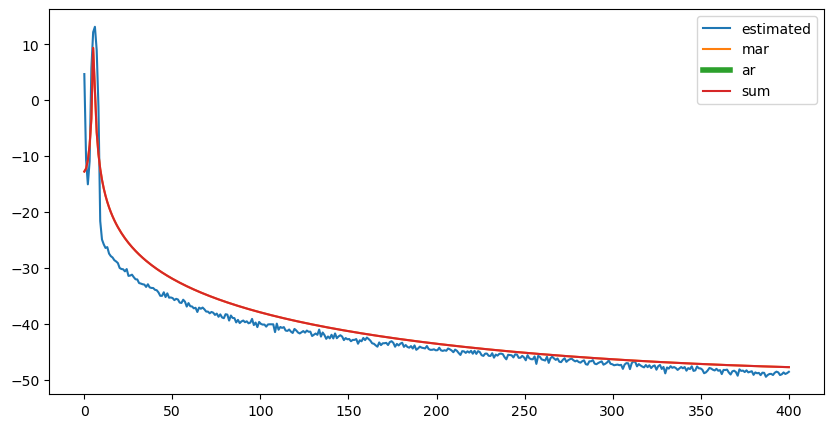

In [6]:

fit_freqs = [6, 200]
q_s_2, r_s_2 = estimate_sigmas([mar_psd_func, ar_noise_psd_func_pink], est_psd_func, fit_freqs)
q_s_est, r_s_est = np.sqrt(q_s_2 * SRATE), np.sqrt(r_s_2 * SRATE)
print(f"{q_s_est=:.4f}, {r_s_est=:.4f}")

fig = plt.figure(figsize=(10, 5))
plt.plot(freqs_plt, [to_db(est_psd_func(f)) for f in freqs_plt], label="estimated")
plt.plot(freqs_plt, [to_db(mar_psd_func(f) * q_s_2) for f in freqs_plt], label="mar")
plt.plot(
    freqs_plt,
    [to_db(ar_noise_psd_func_pink(f) * r_s_2) for f in freqs_plt],
    label="ar",
    linewidth=2,
)

plt.plot(
    freqs_plt,
    [to_db(mar_psd_func(f) * q_s_2 + ar_noise_psd_func_pink(f) * r_s_2) for f in freqs_plt],
    label="sum",
)
plt.legend()
plt.show()

q_s_est=0.2100, r_s_est=0.0800


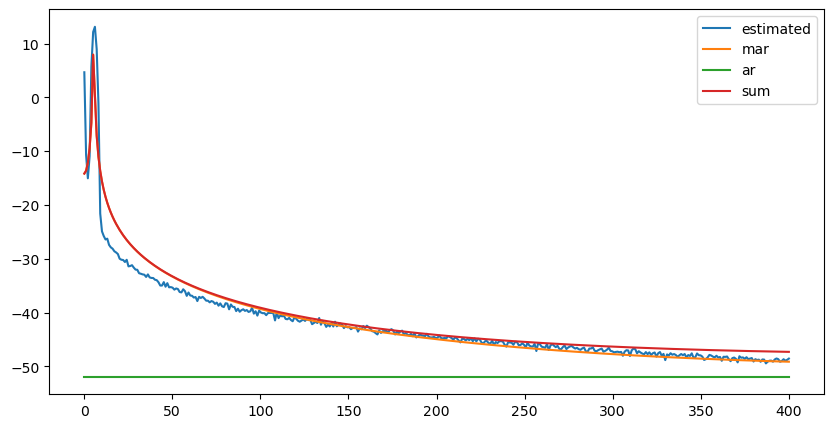

In [7]:

fit_freqs = [6, 400]
q_s_2, r_s_2 = estimate_sigmas([mar_psd_func, ar_noise_psd_func_white], est_psd_func, fit_freqs)
# q_s_est, r_s_est = np.sqrt(q_s_2 * SRATE), np.sqrt(r_s_2 * SRATE)
q_s_est, r_s_est = 0.24, 0.01  # estimated by the EM
q_s_2 = q_s_est**2 / SRATE
r_s_2 = r_s_est**2 / SRATE
print(f"{q_s_est=:.4f}, {r_s_est=:.4f}")

fig = plt.figure(figsize=(10, 5))
plt.plot(freqs_plt, [to_db(est_psd_func(f)) for f in freqs_plt], label="estimated")
plt.plot(freqs_plt, [to_db(mar_psd_func(f) * q_s_2) for f in freqs_plt], label="mar")
plt.plot(freqs_plt, [to_db(ar_noise_psd_func_white(f) * r_s_2) for f in freqs_plt], label="ar")

plt.plot(
    freqs_plt,
    [to_db(mar_psd_func(f) * q_s_2 + ar_noise_psd_func_white(f) * r_s_2) for f in freqs_plt],
    label="sum",
)
plt.legend()
plt.show()